##### **THIS NOTEBOOK IS A PROJECT TO CLASSIFY 525 DIFFERENT BIRD SPECIES**

**Dataset used: https://www.kaggle.com/datasets/gpiosenka/100-bird-species/data **

**Importing necessary libraries**

In [34]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score,f1_score,precision_score

**Applying transformation to both the train,test and valid set**

In [2]:
stats=([0.485,0.456,0.406],[0.229,0.224,0.225])

train_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(10),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

val_transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

**Reading the data and checking length**

In [3]:
train_ds=ImageFolder('/kaggle/input/100-bird-species/train',transform=train_transform)
test_ds=ImageFolder('/kaggle/input/100-bird-species/test',transform=val_transform)
valid_ds=ImageFolder('/kaggle/input/100-bird-species/valid',transform=val_transform)

print(f'Length of training dataset: {len(train_ds)}')
print(f'Length of test dataset: {len(test_ds)}')
print(f'Length of valid dataset: {len(valid_ds)}')

Length of training dataset: 84635
Length of test dataset: 2625
Length of valid dataset: 2625


**Defining the classes**

In [4]:
classes=train_ds.classes
print(f'Number of classes: {len(classes)}')

Number of classes: 525


**Helper function to denormalize and show images from any dataset**

In [5]:
def denormalize(images,means,stds): 
    if len(images.shape)==3:
        images=images.unsqueeze(0)
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_image(img_tensor,label):
    print('Label: ',classes[label],'('+str(label)+')')
    img_tensor=denormalize(img_tensor,*stats)[0].permute((1,2,0))
    plt.imshow(img_tensor)

**Visualizing a few images from train dataset**

Label:  BAR-TAILED GODWIT (62)


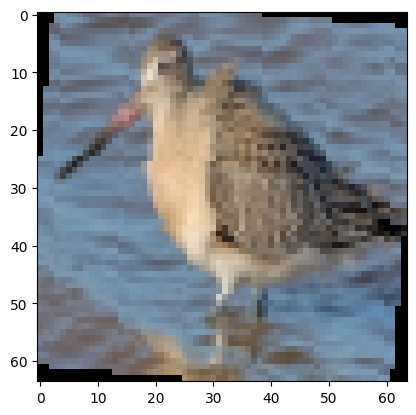

In [6]:
img,label=train_ds[10000]
show_image(img,label)

Label:  ABBOTTS BABBLER (0)


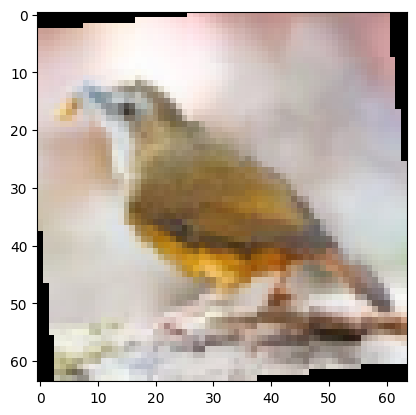

In [7]:
img,label=train_ds[100]
show_image(img,label)

Label:  AFRICAN OYSTER CATCHER (6)


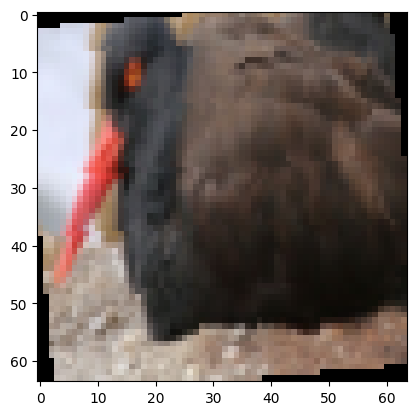

In [8]:
img,label=train_ds[1000]
show_image(img,label)

**Helper functions to get available device (CPU or GPU) and to transfer data to correct device**

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:
device=get_default_device()
print(f'Device being used: {device}')

Device being used: cuda


**Defining train and valid loaders to pass data in batches to the model and transferring data to correct device**

In [11]:
batch_size=256
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size*2,num_workers=4,pin_memory=True)

train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

**Helper accuracy function to get accuracy and a simple ImageClassificationBase class which
inherits from nn.Module to reduce boilerplate code and to keep track of losses and accuracies
of both the train and validation data in the form of a dictionary**

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)  
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        lr = result.get('lr', [0.0])
        train_loss = result.get('train_loss', 0.0)
        val_loss = result.get('val_loss', 0.0)
        val_acc = result.get('val_acc', 0.0)
        train_acc = result.get('train_acc', 0.0)  

        if isinstance(lr, list):
            lr = lr[-1]

        print(f"Epoch [{epoch}], "
              f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

**Helper conv_block function to make the convolutional layers more readable and creating
the Birds class which will be the basis of the model**

In [13]:
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Birds(ImageClassificationBase):
    
    def __init__(self,in_channels,num_classes):
        super().__init__()
        
        self.conv1=conv_block(in_channels,64)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier=nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                     nn.Flatten(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        out=self.classifier(out)
        return out

**Some more helper functions to get the learning rate at every epoch, to evaluate the model performance
on valid dataset and to train the model on the training data**

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []  
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)  
            train_losses.append(loss)
            train_accs.append(acc) 
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()  
        result['lr'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
            
    return history

**Defining our model and putting it on the correct device**

In [15]:
model=to_device(Birds(3,len(classes)),device)
print(f'Birds model: {model}')

Birds model: Birds(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

**Cehcking the shape,device and size of images in the train data**

In [16]:
for batch in train_dl:
    images,labels=batch
    print('images.shape',images.shape)
    print('images.device',images.device)
    preds=model(images)
    print('preds.shape',preds.shape)
    break

images.shape torch.Size([256, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([256, 525])


**Evaluating untrained model on the valid dataset before training to get a baseline performance**

In [17]:
history=[evaluate(model,valid_dl)]
print(history)

[{'val_loss': 6.26308012008667, 'val_acc': 0.0016276041278615594}]


**Training the model for 20 epochs and noting the time taken for training**

In [18]:
import time
start=time.time()
history+=fit_one_cycle(20,0.001,model,train_dl,valid_dl,weight_decay=1e-4,grad_clip=0.1,opt_func=torch.optim.Adam)

print(f'Total time: {(time.time()-start)/60} minutes')

Epoch [0], train_loss: 6.2111, train_acc: 0.0176, val_loss: 5.0478, val_acc: 0.0870
Epoch [1], train_loss: 4.7829, train_acc: 0.1027, val_loss: 3.5245, val_acc: 0.2894
Epoch [2], train_loss: 3.3990, train_acc: 0.2827, val_loss: 2.4042, val_acc: 0.4616
Epoch [3], train_loss: 2.4262, train_acc: 0.4553, val_loss: 1.7725, val_acc: 0.6134
Epoch [4], train_loss: 1.7863, train_acc: 0.5811, val_loss: 1.4195, val_acc: 0.6775
Epoch [5], train_loss: 1.3849, train_acc: 0.6658, val_loss: 1.1057, val_acc: 0.7300
Epoch [6], train_loss: 1.0933, train_acc: 0.7305, val_loss: 0.7963, val_acc: 0.7973
Epoch [7], train_loss: 0.8868, train_acc: 0.7772, val_loss: 0.8056, val_acc: 0.7983
Epoch [8], train_loss: 0.7342, train_acc: 0.8125, val_loss: 0.5823, val_acc: 0.8572
Epoch [9], train_loss: 0.6200, train_acc: 0.8396, val_loss: 0.6260, val_acc: 0.8543
Epoch [10], train_loss: 0.5208, train_acc: 0.8624, val_loss: 0.5396, val_acc: 0.8660
Epoch [11], train_loss: 0.4289, train_acc: 0.8877, val_loss: 0.4493, val_ac

**Evaluating model's metrics on training dataset**

In [19]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_ds:
        inputs = inputs.to(device)
        inputs = torch.cat([inputs, inputs, inputs], dim=1)
        
        inputs = inputs.unsqueeze(0)
        labels = torch.tensor(labels, device=device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.append(labels.item())  

train_accuracy = accuracy_score(all_labels, all_preds)
train_f1 = f1_score(all_labels, all_preds, average='macro')
train_precision = precision_score(all_labels, all_preds, average='macro')

print(f'Train accuracy: {train_accuracy:.4f} | Train f1: {train_f1:.4f} | Train precision: {train_precision:.4f}')

Train accuracy: 0.9866 | Train f1: 0.9868 | Train precision: 0.9871


**Evaluating model's metrics on validation dataset**

In [20]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_ds:
        inputs = inputs.to(device)
        inputs = torch.cat([inputs, inputs, inputs], dim=1)
        
        inputs = inputs.unsqueeze(0)
        labels = torch.tensor(labels, device=device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.append(labels.item())  

valid_accuracy = accuracy_score(all_labels, all_preds)
valid_f1 = f1_score(all_labels, all_preds, average='macro')
valid_precision = precision_score(all_labels, all_preds, average='macro')

print(f'Valid accuracy: {valid_accuracy:.4f} | Valid f1: {valid_f1:.4f} | Valid precision: {valid_precision:.4f}')

Valid accuracy: 0.9333 | Valid f1: 0.9321 | Valid precision: 0.9438


**Evaluating model's metrics on test dataset**

In [21]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_ds:
        inputs = inputs.to(device)
        inputs = torch.cat([inputs, inputs, inputs], dim=1)
        
        inputs = inputs.unsqueeze(0)
        labels = torch.tensor(labels, device=device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.append(labels.item())  

test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='macro')
test_precision = precision_score(all_labels, all_preds, average='macro')

print(f'Test accuracy: {test_accuracy:.4f} | Test f1: {test_f1:.4f} | Test precision: {test_precision:.4f}')

Test accuracy: 0.9619 | Test f1: 0.9611 | Test precision: 0.9684


**FINAL METRICS:**

1.Train accuracy: 98.66%, Train f1: 98.68%, Train precision: 98.71%

2.Valid accuracy: 93.33%, Valid f1: 93.21%, Valid precision: 94.38%

2.Test accuracy: 96.19%, Test f1: 96.11%, Test precision: 96.84%

***These metrics suggest that the model is able to classify unseen images also with high accuracy.***

**Helper functions to plot accuracies,losses and to predict and see images**

In [22]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('acc vs epoch')

def plot_losses(history):
    train_losses=[x.get('train_loss') for x in history]
    val_losses=[x['val_loss'] for x in history]
    plt.plot(train_losses,'-bx')
    plt.plot(val_losses,'-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train','valid'])
    plt.title('loss vs epoch')
    
def predict_image(img, model, classes):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return classes[preds[0].item()]

def predict(index, dataset, model, classes):
    img, label = dataset[index]
    show_image(img, label)
    pred = predict_image(img, model, classes)
    print('Predicted: ', pred)

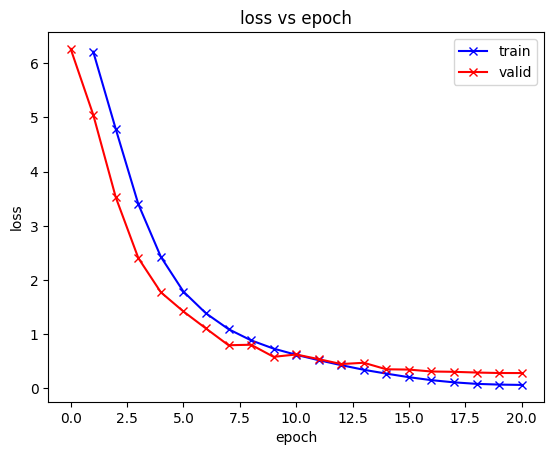

In [23]:
plot_losses(history)

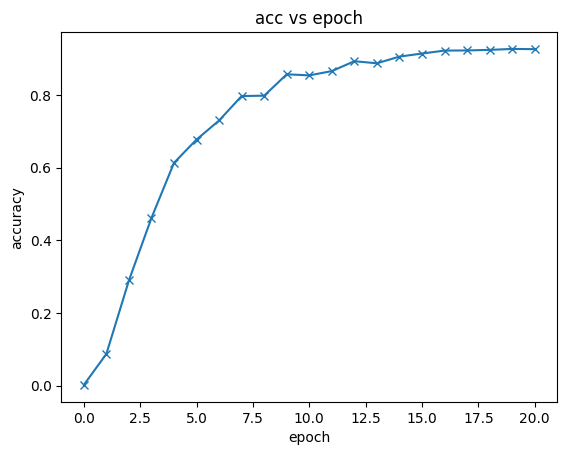

In [24]:
plot_accuracies(history)

Label:  ABBOTTS BABBLER (0)
Predicted:  ABBOTTS BABBLER


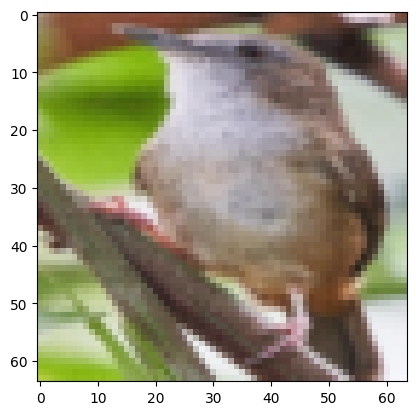

In [25]:
predict(1,test_ds,model,classes)

Label:  AMERICAN KESTREL (20)
Predicted:  AMERICAN KESTREL


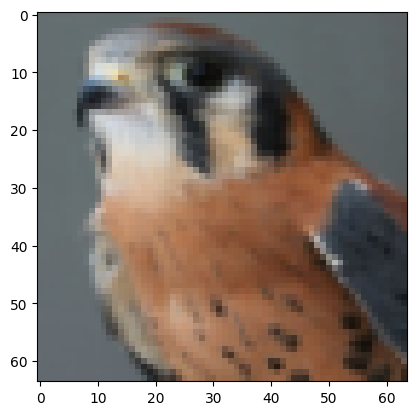

In [26]:
predict(100,test_ds,model,classes)

Label:  ASIAN DOLLARD BIRD (40)
Predicted:  ASIAN DOLLARD BIRD


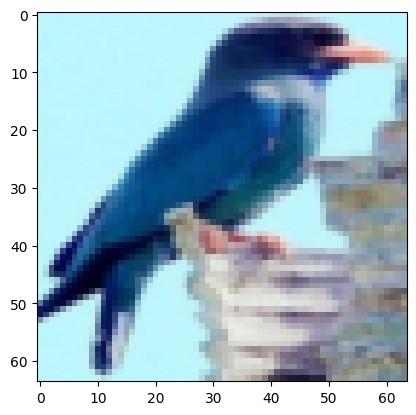

In [27]:
predict(200,test_ds,model,classes)

Label:  EASTERN GOLDEN WEAVER (200)
Predicted:  EASTERN GOLDEN WEAVER


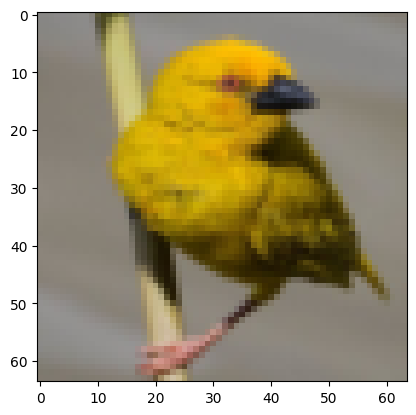

In [28]:
predict(1000,test_ds,model,classes)

Label:  RAZORBILL (400)
Predicted:  RAZORBILL


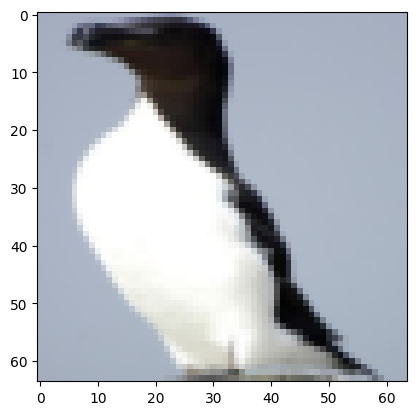

In [30]:
predict(2000,test_ds,model,classes)

Label:  ASIAN DOLLARD BIRD (40)
Predicted:  ASIAN DOLLARD BIRD


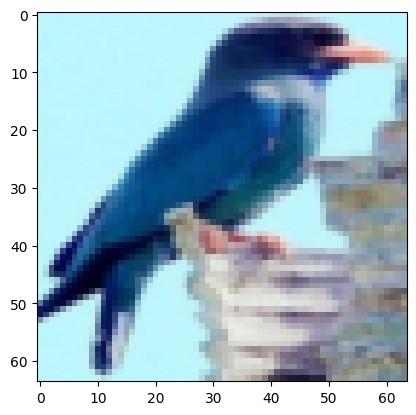

In [31]:
predict(200,test_ds,model,classes)

Label:  BANDED PITA (60)
Predicted:  BANDED PITA


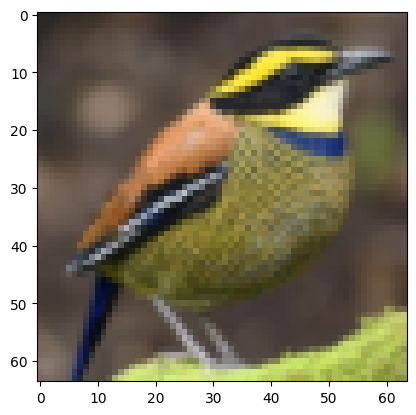

In [35]:
predict(300,test_ds,model,classes)

Label:  BLUE HERON (100)
Predicted:  BLUE HERON


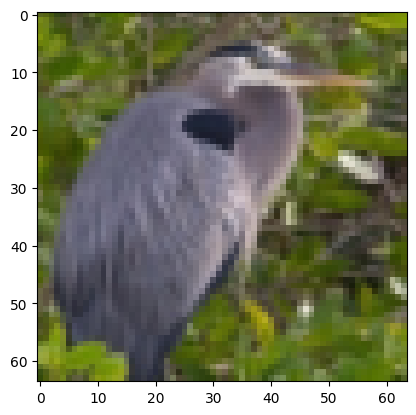

In [36]:
predict(500,test_ds,model,classes)

**Saving the model**

In [32]:
torch.save(model,'525_bird_species.pth')